# Bilayer Sonophore model: computation of intermolecular pressure

### Imports

In [1]:
import logging
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.utils import logger, rmse, rsquared
from PySONIC.neurons import getPointNeuron
from PySONIC.core import BilayerSonophore, PmCompMethod
from PySONIC.constants import *

# Set logging level
logger.setLevel(logging.INFO)

### Functions

In [2]:
def plotPmavg(bls, Z, fs=15):
    fig, ax = plt.subplots(figsize=(5, 3))
    for skey in ['right', 'top']:
        ax.spines[skey].set_visible(False)
    ax.set_xlabel('Z (nm)', fontsize=fs)
    ax.set_ylabel('Pressure (kPa)', fontsize=fs)
    ax.set_xticks([0, bls.a * 1e9])
    ax.set_xticklabels(['0', 'a'])
    ax.set_yticks([-10, 0, 40])
    ax.set_ylim([-10, 50])
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)
    ax.plot(Z * 1e9, bls.v_PMavg(Z, bls.v_curvrad(Z), bls.surface(Z)) * 1e-3, label='$P_m$')
    ax.plot(Z * 1e9, bls.PMavgpred(Z) * 1e-3, label='$P_{m,approx}$')
    ax.axhline(y=0, color='k')
    ax.legend(fontsize=fs, frameon=False)
    fig.tight_layout()

def plotZprofiles(bls, f, A, Q, fs=15):
    # Run simulation with integrated intermolecular pressure
    data, _ = bls.simulate(f, A, Qm, Pm_comp_method=PmCompMethod.direct)
    Z1 = data.loc[-NPC_FULL:, 'Z'].values * 1e9  # nm

    # Run simulation with predicted intermolecular pressure
    data, _ = bls.simulate(f, A, Qm, Pm_comp_method=PmCompMethod.predict)
    Z2 = data.loc[-NPC_FULL:, 'Z'].values * 1e9  # nm
    
    # Plot figure    
    t = np.linspace(0, 1 / f, NPC_FULL) * 1e6  # us
    fig, ax = plt.subplots(figsize=(5, 3))
    for skey in ['right', 'top']:
        ax.spines[skey].set_visible(False)
    ax.set_xlabel('time (us)', fontsize=fs)
    ax.set_ylabel('Deflection (nm)', fontsize=fs)
    ax.set_xticks([t[0], t[-1]])
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)
    
    ax.plot(t, Z1, label='$P_m$')
    ax.plot(t, Z2, label='$P_{m,approx}$')
    ax.axhline(y=0, color='k')
    ax.legend(fontsize=fs, frameon=False)
    fig.tight_layout()
    
    return fig, Z1, Z2 

### Parameters

In [3]:
pneuron = getPointNeuron('RS')
bls = BilayerSonophore(32e-9, pneuron.Cm0, pneuron.Qm0)
f = 500e3
A = 100e3
Qm = pneuron.Qm0

### Profiles comparison over deflection range 

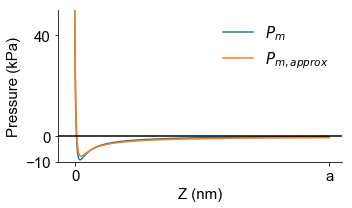

In [4]:
Z = np.linspace(-0.4 * bls.Delta_, bls.a, 1000)
fig = plotPmavg(bls, Z)

### Error quantification over a typical acoustic cycle

Z-error: R2 = 0.9996, RMSE = 0.0454 nm (0.8212% dZ)


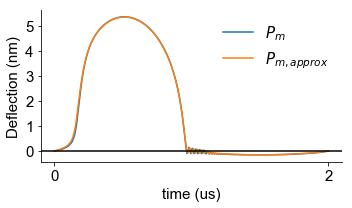

In [5]:
fig, Z1, Z2 = plotZprofiles(bls, f, A, Qm)
error_Z = rmse(Z1, Z2)
r2_Z = rsquared(Z1, Z2)
print('Z-error: R2 = {:.4f}, RMSE = {:.4f} nm ({:.4f}% dZ)'.format(
    r2_Z, error_Z, error_Z / (Z1.max() - Z1.min()) * 1e2))